- NOTE!: HERE We ASSUME that the datasets contains already S21, NOT the output power. We keep track of input power in each the dataset name.

Libraries and functions found on web to display content of a .h5 file

In [30]:
import h5py
import numpy as np
from h5utils import *
import matplotlib.pyplot as plt
from matplotlib import cm
import sys

In [1]:
filename = "13_03_DC_Pump.h5";   # Change HERE!!!

Here you can see the content of the file

In [ ]:
"""PRINT ALL the .h5 file directories"""
h5dump(filename,group = "/")

In [4]:
"""Get simulation parameters"""
params_names, params_values = getDatasetValue(filename,"/",0)

# Print [Check if the order of paramerers is the same of the assegnation below!]
for i in np.arange(0,len(params_names)):
    print(str(params_names[i].decode("utf-8")),": ",str(params_values[i].decode("utf-8")))

# Vna
powerdBm = params_values[0] #[dBm]
navgs = params_values[3]
# Pump
freq_start = float(params_values[1])/1e9 #[GHz]
freq_stop = float(params_values[2])/1e9 #[Ghz]
ampl_min = float(params_values[3]) #[dBm]
ampl_max = float(params_values[4]) #[dBm]
# Bias
volt_min = float(params_values[5]) #[V]
volt_max = float(params_values[6]) #[V]
R = float(params_values[len(params_values)-1])
# You could retrieve current from resistance

# Points densities
n_freq = int(params_values[7])
n_ampl = int(params_values[8])
n_volt = int(params_values[9])

freqs = np.linspace(freq_start, freq_stop, n_freq) 
ampls = np.linspace(ampl_min, ampl_max, n_ampl)
volts = np.linspace(volt_min, volt_max, n_volt)
#volts = [0.227, 0.277, 0.327, 0.377, 0.427]

"""Print parameters arrays"""
print("\n\nIndex:\n")
temp_str = ""
volt_cifers = 3
for i in np.arange(0,n_volt):
    temp_str = temp_str + "[" + str(i) + "] " + str(round(volts[i], volt_cifers)) + "; "
print("Bias Voltage (V): ",temp_str)

temp_str = ""
freq_cifers = 3
for i in np.arange(0,n_freq):
    temp_str = temp_str + "[" + str(i) + "] " + str(round(freqs[i], freq_cifers)) + "; "
print("Pump frequency (GHz): ",temp_str)

temp_str = ""
ampl_cifers = 3
for i in np.arange(0,n_ampl):
    temp_str = temp_str + "[" + str(i) + "] " + str(round(ampls[i], ampl_cifers)) + "; "
print("Pump power (dBm): ",temp_str)

powerdBm :  -15
freq_start :  15722000000.0
freq_stop :  15722000000.0
ampl_min :  -30
ampl_max :  -15
volt_min :  0.11284
volt_max :  0.37324
n_freq :  1
n_ampl :  100
n_volt :  100
navgs :  1
R :  434


Index:

Bias Voltage (V):  [0] 0.113; [1] 0.115; [2] 0.118; [3] 0.121; [4] 0.123; [5] 0.126; [6] 0.129; [7] 0.131; [8] 0.134; [9] 0.137; [10] 0.139; [11] 0.142; [12] 0.144; [13] 0.147; [14] 0.15; [15] 0.152; [16] 0.155; [17] 0.158; [18] 0.16; [19] 0.163; [20] 0.165; [21] 0.168; [22] 0.171; [23] 0.173; [24] 0.176; [25] 0.179; [26] 0.181; [27] 0.184; [28] 0.186; [29] 0.189; [30] 0.192; [31] 0.194; [32] 0.197; [33] 0.2; [34] 0.202; [35] 0.205; [36] 0.208; [37] 0.21; [38] 0.213; [39] 0.215; [40] 0.218; [41] 0.221; [42] 0.223; [43] 0.226; [44] 0.229; [45] 0.231; [46] 0.234; [47] 0.236; [48] 0.239; [49] 0.242; [50] 0.244; [51] 0.247; [52] 0.25; [53] 0.252; [54] 0.255; [55] 0.258; [56] 0.26; [57] 0.263; [58] 0.265; [59] 0.268; [60] 0.271; [61] 0.273; [62] 0.276; [63] 0.279; [64] 0.281; [65] 

In [ ]:
"""Plot (and get) a specific measure"""
dc_volt_index = 19
pump_freq_index = 0
pump_pow_index = 0


group = "/dc_" + str(dc_volt_index) + "/pumpfreq_" + str(pump_freq_index) + "/pumppow_" + str(pump_pow_index)

fmin = 1e9
fmax = 14e9

#group = "Off"

print("Simulation parameters: ")
print("Bias voltage: ", str(round(volts[dc_volt_index], volt_cifers)), " V")
print("Pump frequency: ", str(round(freqs[pump_freq_index], freq_cifers)), " GHz")
print("Pump power: ", str(round(ampls[pump_pow_index], ampl_cifers)), "dBm")
fig, ax = plotDatasetSpectrum(filename, group, 0, fmin, fmax)
xs, ys = getDatasetValue(filename, group, 0)

xoff, yoff = getDatasetValue(filename,"Off",0)

fig2, ax2 = plt.subplots()
ax2.plot(xs,ys-yoff)
ax2.set_title("Difference between Off measure")

In [ ]:
"""Check Bias and Pump OFF pre and after"""

fig, ax = plt.subplots()
xs, yoff1 = getDatasetValue(filename,"Off",0)
xs, yoff2 = getDatasetValue(filename,"Off_end",0)
ax.plot(xs[100:220]/1e9,yoff2[100:220]-yoff1[100:220])
ax.set_title("Difference between ALL OFF measurements\ntaken at the beginning and at the end")
ax.set_xlabel("frequency [GHz]")
ax.set_ylabel("gain [dBm]")

NOTE!: Both 'Off' measurement and 'On' measurements need to be present in the SAME .h5 file and must be taken adopting the same parameters for the VNA!

- Consider many selected measurements (all the ones associated to the chosen parameters)
- Subtract the 'Off' measure
- Plot all those measurements on the same canvas in the desired span [ fmin,fmax ]

In [ ]:
"""Gain of some selected experiments"""
voltage_indexes = [0]
frequency_indexes = [0,5,10,19]
power_indexes = [0]

fmin = 5e9 #[GHz]
fmax = 8e9 #[GHz]
fspan = fmax - fmin


fig, ax = plt.subplots()
# Get 'Off' measurement (will be subtracted to all measurements)
xoff, yoff = getDatasetValue(filename, "/Off", 0)
# Check if the frequency span [fmin,fmax] is valid
if xoff[0] <= fmin and xoff[len(xoff)-1] >= fmax:
    print("Band: [",round(fmin/1e9,freq_cifers),", ",round(fmax/1e9,freq_cifers),"] GHz")
else:
    print("Invalid frequency span!")
    exit()
# Get i_min, i_max for the defined band
df = xoff[1] - xoff[0]
i_min = round((fmin - xoff[0])/df)
i_max = round(len(xoff) - 1 - (xoff[len(xoff)-1] - fmax)/df)
n_pts = i_max - i_min

for k in voltage_indexes:
    for j in power_indexes:
        for i in frequency_indexes:
            # Get desired dataset
            group = "/dc_" + str(k) + "/pumpfreq_" + str(i) + "/pumppow_" + str(j)
            print(group)
            temp_xs, temp_ys = getDatasetValue(filename, group, 0)
            # Remove the 'Off' measurement
            temp_ys = temp_ys - yoff

            # Focus on the defined BAND
            xs = temp_xs[i_min:i_max]
            ys = temp_ys[i_min:i_max]

            # Plot S21 in the desired Fspan and get 'gain band average'
            ax.plot(xs/1e9,ys,label=(str(round(volts[k],volt_cifers))+"V,"+str(round(ampls[j],ampl_cifers))+"dBm,"+str(round(freqs[i],freq_cifers))+"GHz, pts"+str(n_pts)))

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.grid()
ax.set_xlabel("Signal frequency [GHz]")
ax.set_ylabel("S21")
ax.set_title("Paramp gain\n['Off' measurement subtracted]")

Find optimal parameters among *ALL* the measurements in the .h5 file

Band: [ 5.0 ,  8.0 ] GHz
Best params:  0.3101127272727273 V,  15.722 GHz,  -15.0 dBm
Best Band average gain:  5.904 dB


Text(0, 0.5, 'Averaged gain [dB]')

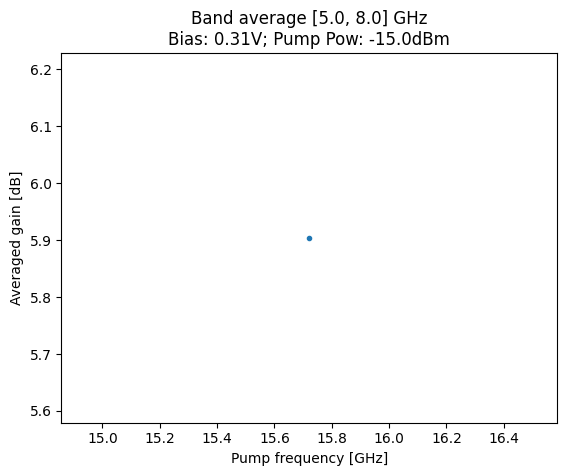

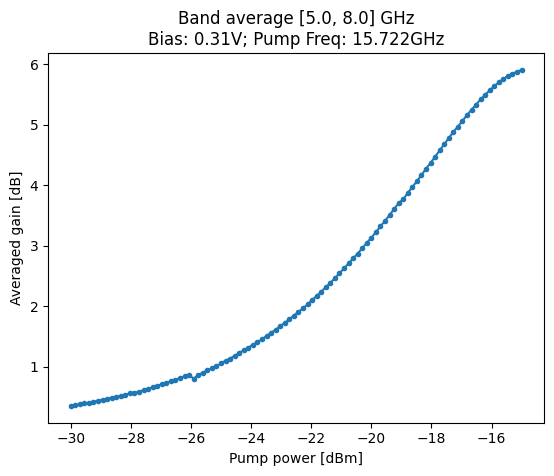

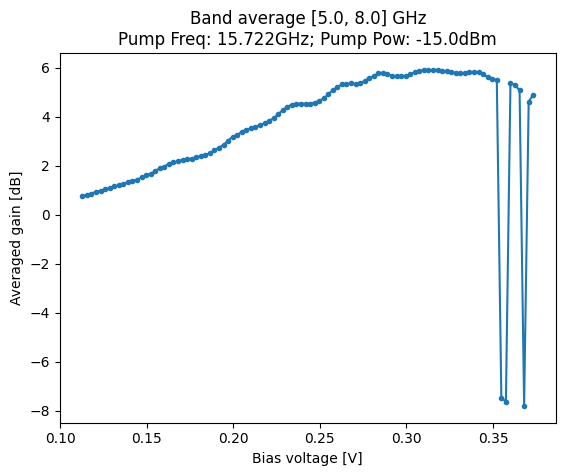

In [6]:
"""BEST PARAMETERS"""

fmin = 5e9 #[GHz]
fmax = 8e9 #[GHz]
fspan = fmax - fmin


# Get 'Off' measurement (will be subtracted to all measurements)
xoff, yoff = getDatasetValue(filename, "/Off", 0)
group = "/dc_" + "0" + "/pumpfreq_" + "0" + "/pumppow_" + "0"
#xoff, yoff = getDatasetValue(filename, group, 0)
#yoff = np.zeros(len(yoff))

# Check if the frequency span [fmin,fmax] is valid
if xoff[0] <= fmin and xoff[len(xoff)-1] >= fmax:
    print("Band: [",round(fmin/1e9,freq_cifers),", ",round(fmax/1e9,freq_cifers),"] GHz")
else:
    sys.exit("Invalid frequency span!")
# Get i_min, i_max for the defined band
df = xoff[1] - xoff[0]
i_min = round((fmin - xoff[0])/df)
i_max = round(len(xoff) - 1 - (xoff[len(xoff)-1] - fmax)/df)
n_pts = i_max - i_min

band_averages = np.zeros((len(volts),len(freqs),len(ampls)))
max_average = [0,0,0]    # Indexes of params for best band average
for k in np.arange(0,len(volts)):
    for j in np.arange(0,len(ampls)):
        for i in np.arange(0,len(freqs)):
            # Get desired dataset
            group = "/dc_" + str(k) + "/pumpfreq_" + str(i) + "/pumppow_" + str(j)
            try:
                temp_xs, temp_ys = getDatasetValue(filename, group, 0)
                # Remove the 'Off' measurement
                temp_ys = temp_ys - yoff
                # Focus on the defined BAND
                xs = temp_xs[i_min:i_max]
                ys = temp_ys[i_min:i_max]

                band_averages[k,i,j] = np.mean(ys)
                if band_averages[max_average[0],max_average[1],max_average[2]] < band_averages[k,i,j]:
                    max_average = [k,i,j]
            except:
                print(i)

# Get params for maximum band average
best_voltage = volts[max_average[0]]
best_freq = freqs[max_average[1]]
best_pow = ampls[max_average[2]]
print("Best params: ",best_voltage,"V, ",best_freq,"GHz, ",best_pow,"dBm")
print("Best Band average gain: ",round(band_averages[max_average[0],max_average[1],max_average[2]],3),"dBm")

# Plot band average varying only Pump frequency (other two params fixed at 'optimal' values)
fig_freq, ax_freq = plt.subplots()
ax_freq.plot(freqs, band_averages[max_average[0],:,max_average[2]],'.-')
ax_freq.set_title("Band average ["+str(round(fmin/1e9,freq_cifers))+", "+str(round(fmax/1e9,freq_cifers))+"] GHz\nBias: "+str(round(best_voltage,volt_cifers))+"V; Pump Pow: "+str(round(best_pow,ampl_cifers))+"dBm")
ax_freq.set_xlabel("Pump frequency [GHz]")
ax_freq.set_ylabel("Averaged gain [dB]")

# Plot band average varying only Pump power (other two params fixed at 'optimal' values)
fig_pow, ax_pow = plt.subplots()
ax_pow.plot(ampls, band_averages[max_average[0],max_average[1],:],'.-')
ax_pow.set_title("Band average ["+str(round(fmin/1e9,freq_cifers))+", "+str(round(fmax/1e9,freq_cifers))+"] GHz\nBias: "+str(round(best_voltage,volt_cifers))+"V; Pump Freq: "+str(round(best_freq,freq_cifers))+"GHz")
ax_pow.set_xlabel("Pump power [dBm]")
ax_pow.set_ylabel("Averaged gain [dB]")

# Plot band average varying only Bias voltage (other two params fixed at 'optimal' values)
fig_freq, ax_freq = plt.subplots()
ax_freq.plot(volts, band_averages[:,max_average[1],max_average[2]],'.-')
ax_freq.set_title("Band average ["+str(round(fmin/1e9,freq_cifers))+", "+str(round(fmax/1e9,freq_cifers))+"] GHz\nPump Freq: "+str(round(best_freq,freq_cifers))+"GHz; Pump Pow: "+str(round(best_pow,ampl_cifers))+"dBm")
ax_freq.set_xlabel("Bias voltage [V]")
ax_freq.set_ylabel("Averaged gain [dB]")

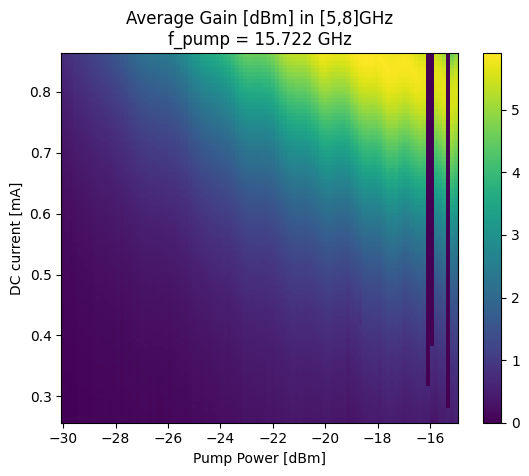

In [44]:
"""3D PLOT"""
from mpl_toolkits.mplot3d import Axes3D


best_gain = round(band_averages[max_average[0],max_average[1],max_average[2]],3)
# In order to have a more precise colormap, we exclude values less than a
# selected one, assigning them to this selected value
minimum_plot_gain = 0 #[dBm]


B, D = np.meshgrid(ampls, volts)
nu = np.zeros((len(ampls),len(volts)))
for x in np.arange(0,len(B)):
    for y in np.arange(0,len(D)):
        if band_averages[y,0,x] < minimum_plot_gain:
            nu[x,y] = minimum_plot_gain
        else:
            nu[x,y] = band_averages[y,0,x]

D = D/R*1e3 # Voltage [V] to current [mA]
fig = plt.figure()
plt.pcolor(B, D, nu, vmin=minimum_plot_gain, vmax=best_gain)
plt.colorbar()
plt.xlabel('Pump Power [dBm]')
plt.ylabel('DC current [mA]')
plt.title('Average Gain [dBm] in [5,8]GHz\nf_pump = 15.722 GHz')
plt.show()

In [ ]:
"""DELETE a dataset"""
full_dataset_path = "/group/dataset_to_delete"
deleteDataset(filename, full_dataset_path)

In [ ]:
"""Save a dataset"""
filename_save = "save.h5"
full_dataset_path = "/group/datasetname"

mat = [xs1, ys1]
hf = h5py.File(filename_save, 'a')
hf.create_dataset(full_dataset_path, data = mat)
hf.close()